In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from PIL import Image, ImageDraw
from torchvision.transforms.functional import pil_to_tensor


def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    """
    Rescale and display an image represented as a tensor or PIL Image.
    The function scales the img to the [0, 1] range.
    The img is assumed to have shape 3xHxW (RGB) or 1xHxW (grayscale).

    Args:
        img (torch.Tensor or PIL.Image): image.
        quiet (bool, optional): if False, display image. Default: False.
        lim (list, optional): [min, max] for rescaling. Default: None.
        interpolation (str, optional): Interpolation mode for imshow. Default: 'lanczos'.

    Returns:
        numpy.ndarray: Rescaled image as numpy array.
    """
    if isinstance(img, Image.Image):
        img = pil_to_tensor(img).float()
    handle = None
    with torch.no_grad():
        if lim is None:
            lim = [img.min(), img.max()]
        img = img - lim[0]  # also makes a copy
        img.mul_(1 / (lim[1] - lim[0]))
        img = torch.clamp(img, min=0, max=1)
        if not quiet:
            # Ensure 3 channels for display
            if img.shape[0] == 1:
                img = img.expand(3, *img.shape[1:])
            bitmap = img.permute(1, 2, 0).cpu().numpy()
            return bitmap
        else:
            return img

/Users/jazav7774/Library/CloudStorage/OneDrive-UiTOffice365/UiT/NORA_MML/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
coco_images = torch.load('data/example_images_coco.pth', map_location=torch.device('mps'))

In [ ]:
coco_labels = torch.load('data/example_labels_coco.pth', map_location=torch.device('mps'))
print(f"Loaded {len(coco_labels)} ground truth labels.")

Loaded 200 ground truth labels.


In [3]:
processor = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-tiny")
model = AutoModelForZeroShotObjectDetection.from_pretrained("IDEA-Research/grounding-dino-tiny")

In [55]:
coco_categories = "person.bicycle.car.motorcycle.airplane.bus.train.truck.boat.traffic light.fire hydrant.stop sign.parking meter.bench.bird.cat.dog.horse.sheep.cow.elephant.bear.zebra.giraffe.backpack.umbrella.handbag.tie.suitcase.frisbee.skis.snowboard.sports ball.kite.baseball bat.baseball glove.skateboard.surfboard.tennis racket.bottle.wine glass.cup.fork.knife.spoon.bowl.banana.apple.sandwich.orange.broccoli.carrot.hot dog.pizza.donut.cake.chair.couch.potted plant.bed.dining table.toilet.tv.laptop.mouse.remote.keyboard.cell phone.microwave.oven.toaster.sink.refrigerator.book.clock.vase.scissors.teddy bear.hair drier.toothbrush"
print(f"Created coco_categories string with {len(coco_categories.split('.'))} categories.")

Created coco_categories string with 80 categories.


In [57]:
def detect_objects_on_coco_image(image_index, text_prompts_str, coco_labels):
    """
    Performs zero-shot object detection on a specified image from coco_images
    using a given text prompt. Displays the image with detections and prints results.

    Args:
        image_index (int): Index of the image in the global coco_images tensor.
        text_prompts_str (str): Text prompt describing objects to detect (e.g., "a cat . a dog .").
    
    Returns:
        dict: A dictionary containing the detection results (scores, labels, boxes), or None if an error occurs.
    """
    # Ensure global variables coco_images, processor, model are accessible.
    # Ensure necessary imports: Image, ImageDraw, plt, torch, np are available from previous cells.

    # 1. Select and prepare the image from coco_images
    if not (0 <= image_index < len(coco_images)):
        print(f"Error: image_index {image_index} is out of bounds for coco_images (size {len(coco_images)}).")
        return None
        
    image_tensor = coco_images[image_index] # Expected shape: (C, H, W)

    # Permute to HWC for PIL and Matplotlib if it's CHW
    processed_image_tensor = image_tensor
    if len(image_tensor.shape) == 3 and image_tensor.shape[0] == 3: # CHW
        processed_image_tensor = image_tensor.permute(1, 2, 0) # HWC
    # Add handling for other shapes if necessary, though coco_images[idx] should be (C,H,W)

    image_np = processed_image_tensor.cpu().numpy()

    # Normalize to 0-1 range based on its own min/max, then scale to 0-255 for PIL
    min_val = image_np.min()
    max_val = image_np.max()
    if max_val == min_val: # Handle uniform images (e.g., all black or all white)
        image_scaled_np = np.zeros_like(image_np, dtype=np.float32)
    else:
        image_scaled_np = (image_np - min_val) / (max_val - min_val)
    
    # Convert to PIL Image. Assumes image_scaled_np is HWC and in [0,1]
    image_pil = Image.fromarray((image_scaled_np * 255).astype(np.uint8))

    # 2. Prepare inputs for the model
    inputs = processor(images=image_pil, text=text_prompts_str, return_tensors="pt")
    
    # Optionally, move inputs to model.device if experiencing device mismatches
    # inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # 3. Get model outputs
    with torch.no_grad():
        outputs = model(**inputs)

    # 4. Post-process the outputs
    target_sizes = [image_pil.size[::-1]]  # PIL size is (width, height), model expects (height, width)
    
    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids, 
        box_threshold=0.4, 
        text_threshold=0.3, 
        target_sizes=target_sizes
    )[0] # Get results for the first (and only) image processed

    # 5. Draw bounding boxes
    draw = ImageDraw.Draw(image_pil)
    for score, label, box in zip(results["scores"], results["text_labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        draw.rectangle(box, outline="red", width=1) # Using width=1 as per current notebook state
        draw.text((box[0], box[1]-10), f"{label}: {round(score.item(), 2)}", fill="red")

    # 6. Display the image with detections and the ground truth label side by side
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    # Left: Detected objects
    axs[0].imshow(image_pil)
    axs[0].axis('off')
    axs[0].set_title(f"Detections for prompt: '{text_prompts_str if len(text_prompts_str) < 50 else 'COCO labels'}'\nimage index {image_index}")

    # Right: Ground truth label mask
    gt_mask = coco_labels[image_index].cpu().numpy()
    axs[1].imshow(gt_mask, cmap='tab20')
    axs[1].axis('off')
    axs[1].set_title("COCO Ground Truth Label")

    plt.tight_layout()
    plt.show()

    # 7. Print detection details
    print(f"Detected objects: {results['labels']}")
    print(f"Scores: {results['scores']}")
    print(f"Boxes: {results['boxes']}")

    return results

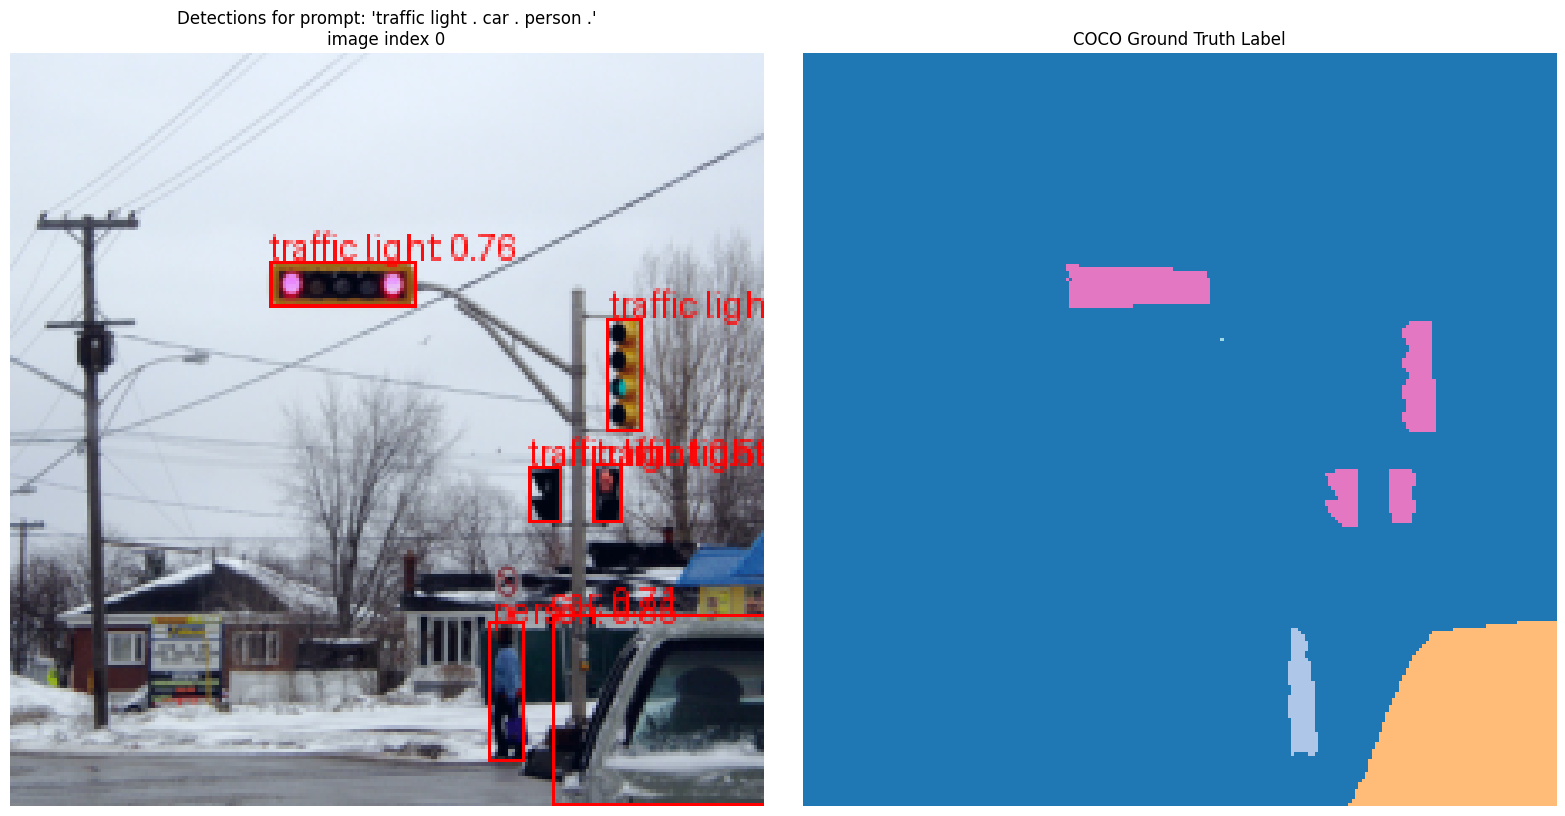

Detected objects: ['person', 'traffic light', 'traffic light', 'traffic light', 'car', 'traffic light']
Scores: tensor([0.8454, 0.7618, 0.7596, 0.5888, 0.7084, 0.6189])
Boxes: tensor([[142.5183, 169.8460, 152.9697, 210.1744],
        [177.7057,  79.0679, 187.3026, 112.9046],
        [ 77.0331,  62.2004, 120.2772,  75.8895],
        [154.1800, 123.3567, 163.9796, 139.4818],
        [161.0001, 167.4086, 224.0224, 223.9789],
        [173.8758, 122.9494, 181.9034, 139.4146]])


{'scores': tensor([0.8454, 0.7618, 0.7596, 0.5888, 0.7084, 0.6189]),
 'boxes': tensor([[142.5183, 169.8460, 152.9697, 210.1744],
         [177.7057,  79.0679, 187.3026, 112.9046],
         [ 77.0331,  62.2004, 120.2772,  75.8895],
         [154.1800, 123.3567, 163.9796, 139.4818],
         [161.0001, 167.4086, 224.0224, 223.9789],
         [173.8758, 122.9494, 181.9034, 139.4146]]),
 'text_labels': ['person',
  'traffic light',
  'traffic light',
  'traffic light',
  'car',
  'traffic light'],
 'labels': ['person',
  'traffic light',
  'traffic light',
  'traffic light',
  'car',
  'traffic light']}

In [54]:
detect_objects_on_coco_image(0, "traffic light . car . person .", coco_labels)

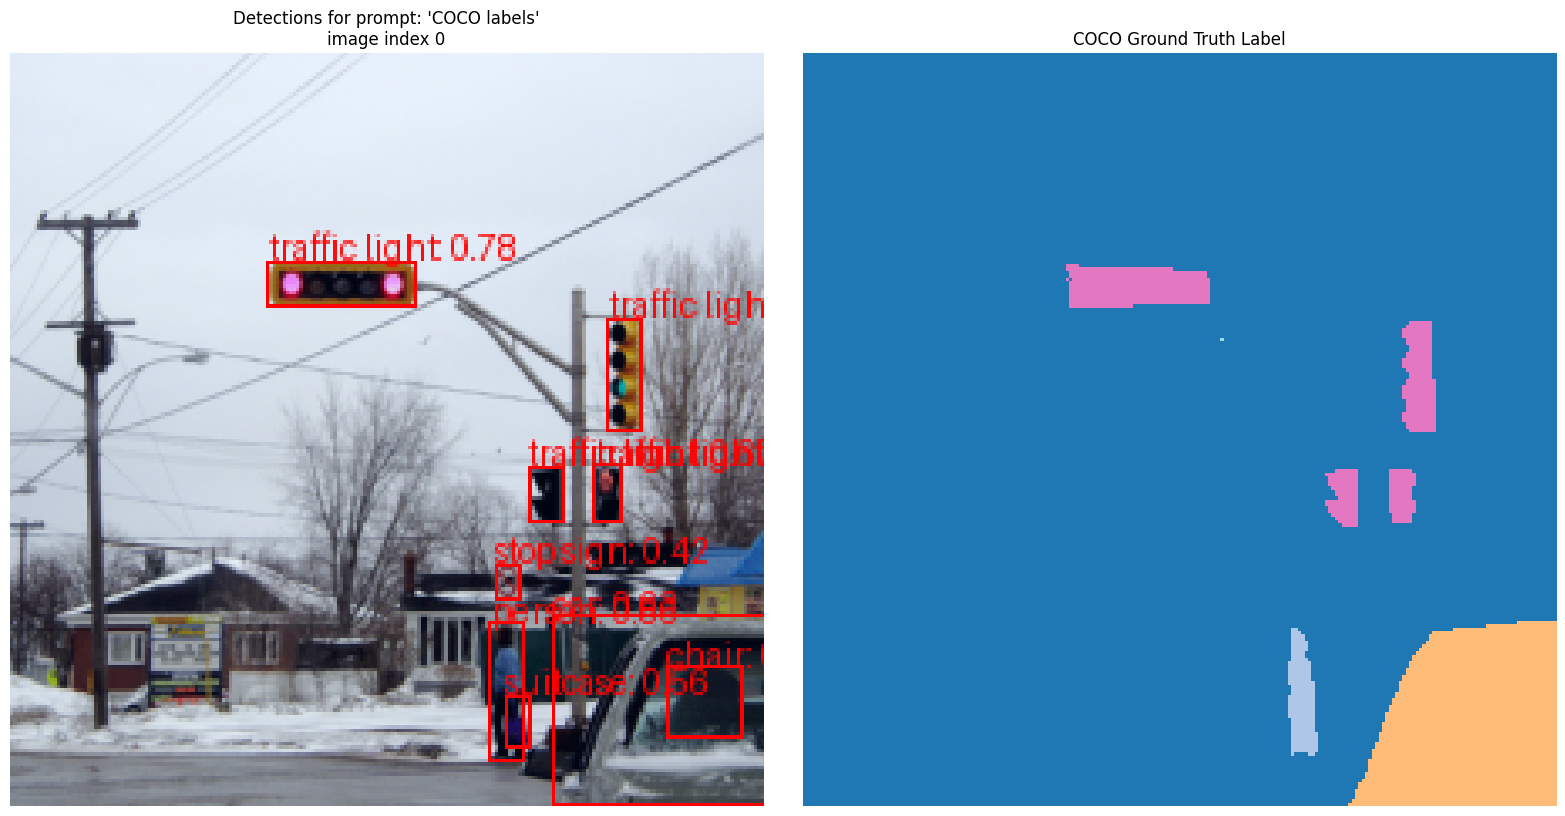

Detected objects: ['person', 'traffic light', 'traffic light', 'traffic light', 'traffic light', 'car', 'suitcase', 'stop sign', 'chair']
Scores: tensor([0.8575, 0.7801, 0.7823, 0.6661, 0.6932, 0.6264, 0.5567, 0.4219, 0.4619])
Boxes: tensor([[142.5670, 169.8686, 152.8151, 210.1379],
        [177.7151,  79.0627, 187.2853, 112.8828],
        [ 76.9858,  62.2338, 120.2909,  75.9270],
        [154.1617, 123.3097, 164.0381, 139.4329],
        [173.8165, 122.9270, 181.9281, 139.4019],
        [161.1169, 167.5376, 224.0330, 223.9433],
        [147.0620, 191.3648, 154.0732, 206.3265],
        [144.0562, 152.2689, 151.3555, 162.2775],
        [195.3334, 182.5827, 217.7844, 203.2131]])


/Users/jazav7774/Library/CloudStorage/OneDrive-UiTOffice365/UiT/NORA_MML/.venv/lib/python3.12/site-packages/transformers/models/grounding_dino/processing_grounding_dino.py:95: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


{'scores': tensor([0.8575, 0.7801, 0.7823, 0.6661, 0.6932, 0.6264, 0.5567, 0.4219, 0.4619]),
 'boxes': tensor([[142.5670, 169.8686, 152.8151, 210.1379],
         [177.7151,  79.0627, 187.2853, 112.8828],
         [ 76.9858,  62.2338, 120.2909,  75.9270],
         [154.1617, 123.3097, 164.0381, 139.4329],
         [173.8165, 122.9270, 181.9281, 139.4019],
         [161.1169, 167.5376, 224.0330, 223.9433],
         [147.0620, 191.3648, 154.0732, 206.3265],
         [144.0562, 152.2689, 151.3555, 162.2775],
         [195.3334, 182.5827, 217.7844, 203.2131]]),
 'text_labels': ['person',
  'traffic light',
  'traffic light',
  'traffic light',
  'traffic light',
  'car',
  'suitcase',
  'stop sign',
  'chair'],
 'labels': ['person',
  'traffic light',
  'traffic light',
  'traffic light',
  'traffic light',
  'car',
  'suitcase',
  'stop sign',
  'chair']}

In [58]:
detect_objects_on_coco_image(0, coco_categories, coco_labels) 

In [ ]:
# Example usage of the new function:
# Ensure coco_labels is loaded in a previous cell
plot_ground_truth_on_image(0, coco_labels)